In [ ]:
 %pip install scikit-learn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import random
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [ ]:
df=pd.read_csv("train.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443276 entries, 0 to 1443275
Data columns (total 91 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   pitch_uid                        1443276 non-null  int64  
 1   game_pk                          1443276 non-null  int64  
 2   game_date                        1443276 non-null  object 
 3   pitcher                          1443276 non-null  int64  
 4   pitcher_name                     1443276 non-null  object 
 5   batter                           1443276 non-null  int64  
 6   batter_name                      1443276 non-null  object 
 7   pitch_type                       1443276 non-null  object 
 8   release_speed                    1443276 non-null  float64
 9   release_pos_x                    1443276 non-null  float64
 10  release_pos_z                    1443276 non-null  float64
 11  events                           367520 non-null  

In [ ]:
df.dtypes

pitch_uid               int64
game_pk                 int64
game_date              object
pitcher                 int64
pitcher_name           object
                       ...   
spin_axis             float64
delta_home_win_exp    float64
delta_run_exp         float64
attack_zone            object
swing                   int64
Length: 91, dtype: object

In [ ]:
#variables que nos interesan
new_df=df[["pitch_type","release_speed","release_pos_x","release_pos_z","zone","pfx_x","pfx_z","plate_x","plate_z","vx0",
          "vy0","vz0","ax","ay","az","effective_speed","release_spin_rate","release_extension","release_pos_y","spin_axis","swing"]]

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443276 entries, 0 to 1443275
Data columns (total 21 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pitch_type         1443276 non-null  object 
 1   release_speed      1443276 non-null  float64
 2   release_pos_x      1443276 non-null  float64
 3   release_pos_z      1443276 non-null  float64
 4   zone               1443276 non-null  float64
 5   pfx_x              1443276 non-null  float64
 6   pfx_z              1443276 non-null  float64
 7   plate_x            1443276 non-null  float64
 8   plate_z            1443276 non-null  float64
 9   vx0                1443276 non-null  float64
 10  vy0                1443276 non-null  float64
 11  vz0                1443276 non-null  float64
 12  ax                 1443276 non-null  float64
 13  ay                 1443276 non-null  float64
 14  az                 1443276 non-null  float64
 15  effective_speed    1443276 non-n

In [ ]:
new_df.dtypes

pitch_type            object
release_speed        float64
release_pos_x        float64
release_pos_z        float64
zone                 float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
effective_speed      float64
release_spin_rate    float64
release_extension    float64
release_pos_y        float64
spin_axis            float64
swing                  int64
dtype: object

In [ ]:
new_df.isnull().sum().sum()

0

In [ ]:
#valores nulos
all_data_na = (new_df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'% De valores nulos' :all_data_na})
missing_data.head(20)

,% De valores nulos


In [ ]:
#Duplicados
new_df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1443271    False
1443272    False
1443273    False
1443274    False
1443275    False
Length: 1443276, dtype: bool

In [ ]:
sum(new_df.duplicated())

0

In [ ]:
#SEPARAMOS VARIABLES CUANTITATIVAS Y CUALITATIVAS
quantitative = [f for f in new_df.columns if new_df.dtypes[f] != 'object']
qualitative = [f for f in new_df.columns if new_df.dtypes[f] == 'object']

In [ ]:
print("Quantitaive Features",quantitative)
print("")
print("Qualitaive Features",qualitative)

Quantitaive Features ['release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis', 'swing']

Qualitaive Features ['pitch_type']


In [ ]:
#VEMOS NUMERO DE PITCH TYPE 
new_df["pitch_type"].unique()

array(['FF', 'SL', 'KC', 'CH', 'CU', 'SI', 'FC', 'CS', 'FS', 'ST', 'SV',
       'FA', 'PO', 'EP', 'KN', 'SC'], dtype=object)

In [ ]:
#YA QUE PITCH TYPE NO SON VARIABLES JERARQUICAS OPTAMOS POR USAR ONE HOT ENCODER QUE
# ES MAS EFICIENTE PARA ESTE CASO 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
encoded_array = ohe.fit_transform(new_df[['pitch_type']]).toarray()
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(['pitch_type']))
new_df_encoded = pd.concat([new_df, encoded_df], axis=1)
new_df_encoded.drop(columns="pitch_type",inplace=True)

In [ ]:
new_df_encoded

,release_speed,release_pos_x,release_pos_z,zone,pfx_x,pfx_z,plate_x,plate_z,vx0,vy0,...,pitch_type_FF,pitch_type_FS,pitch_type_KC,pitch_type_KN,pitch_type_PO,pitch_type_SC,pitch_type_SI,pitch_type_SL,pitch_type_ST,pitch_type_SV
0,95.2,2.19,6.19,5.0,0.68,1.55,-0.23,2.17,-7.905302,-138.131797,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,94.9,1.96,6.32,11.0,0.86,1.51,-1.41,2.68,-10.742471,-137.510314,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87.9,2.25,6.10,13.0,0.43,0.44,-0.85,0.68,-8.409080,-127.473926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,88.2,2.44,5.96,13.0,0.08,0.45,-0.92,-0.54,-8.314469,-127.908376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,95.8,1.93,6.23,13.0,0.74,1.51,-1.35,2.03,-10.351316,-138.879980,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443271,88.3,2.28,5.51,12.0,1.11,0.94,0.87,2.85,-5.739170,-128.563371,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443272,88.1,-2.33,5.75,4.0,-1.16,0.28,-0.33,2.30,7.273766,-128.090642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443273,88.7,-2.58,5.57,13.0,-1.19,0.42,-2.53,2.34,2.603118,-129.141453,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1443274,76.7,-2.48,4.86,2.0,1.04,-0.17,0.00,2.71,3.365469,-111.701598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#NOTEMOS QUE SWING SON DOS TIPOS DE VARIABLES
new_df_encoded["swing"].unique()

array([0, 1])

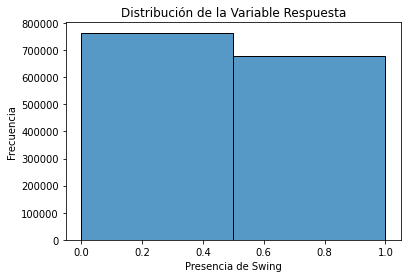

In [ ]:
#NOTEMOS QUE NO EXISTE MUCHO DESBALANCEO DE LOS DATOS QUE ES IMPORTANTE
sns.histplot(new_df_encoded, x='swing', bins=2)
plt.xlabel('Presencia de Swing')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Respuesta')
plt.show()

In [ ]:
new_df_encoded["swing"].value_counts().sort_index()

0    764736
1    678540
Name: swing, dtype: int64

In [ ]:
764736 + 678540

1443276

In [ ]:
764736/1443276

0.5298612323630407

In [ ]:
#Correlaciones
corr_Y_X=pd.DataFrame(new_df_encoded[new_df_encoded.columns[:]].corr()['swing'][:])
corr_Y_X["swing"].sort_values()

zone                -0.358011
pitch_type_CU       -0.043751
vy0                 -0.035093
plate_x             -0.024383
release_spin_rate   -0.017379
pitch_type_SI       -0.016595
pitch_type_KC       -0.014952
pfx_x               -0.010426
release_pos_y       -0.008404
ax                  -0.008259
pitch_type_PO       -0.006560
vx0                 -0.005968
pitch_type_SV       -0.003331
pitch_type_ST       -0.002644
pitch_type_CS       -0.002406
pitch_type_KN       -0.001327
pitch_type_EP       -0.001127
pitch_type_FA       -0.000897
release_pos_z       -0.000260
pitch_type_SC        0.000983
release_pos_x        0.001791
pitch_type_SL        0.006524
pitch_type_FF        0.008111
release_extension    0.008352
pitch_type_FS        0.014233
pitch_type_FC        0.015743
spin_axis            0.017125
vz0                  0.020125
ay                   0.020997
az                   0.023129
pitch_type_CH        0.026577
pfx_z                0.028276
release_speed        0.032219
effective_

In [ ]:
#NOTAMOS QUE NO TIENEN COLAS PESADAS, LAS QUE MUESTRAN COLAS PESADAS SON AQUELLAS 
#QUE USAMOS ONE HOT LABEL ENCODER ENTONCES EN GENERAL TODAS LAS VARIABLES ESTAN 
#DECENTES PARA MODELAR

numeric_feats = new_df_encoded.dtypes[new_df_encoded.dtypes != "object"].index
skewed_feats = new_df_encoded[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
pitch_type_SC,400.450996
pitch_type_PO,143.580043
pitch_type_KN,108.309516
pitch_type_EP,64.376588
pitch_type_CS,60.965431
pitch_type_FA,27.742260
pitch_type_SV,17.503919
pitch_type_ST,8.214201
pitch_type_FS,7.762692
pitch_type_KC,6.543941


In [ ]:
# Muestreo Aleatorio
sample_df = new_df_encoded.sample(n=10000, random_state=42)

In [ ]:
x=sample_df.drop('swing', axis=1)
y=sample_df['swing']

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25, random_state=0)

In [ ]:
#STANDARIZING DATA COVERT DATA TO VARIANCE 1 AND MAKE A GENERAL MEAN 
sc=StandardScaler().fit(x_train)
x_train=sc.transform(x_train)
x_test=sc.transform(x_test)

In [ ]:
#Modelos

In [ ]:
#SVM

In [ ]:
def grid_search_clf_svm(x_train, y_train, C=None, gamma = None, search_delta_svm=0.25):

    # extraemos los valores 'y' para clasificar del dataframe que alberga los datos
    y = y_train
    x = x_train

    # parametros de la malla de busqueda
    svm_clf = svm.SVC(class_weight='balanced', probability=False)
    
    if (C is None):
        # Parametros de la malla: ojo con la definicion ->  classifier__ // dos guiones bajos antes del parametro
        grid_params = {}
        grid_params['kernel'] = ['rbf']
        grid_params['C'] = [2**k for k in range(-5,16)] 
        grid_params['gamma'] = [2**k for k in range(-15, 4)]
    else:
        grid_params = {}
        grid_params['kernel'] = ['rbf']
        grid_params['C'] = [2**(C+(k*search_delta_svm)) for k in range(-8,8)] # np.arange(0.1,4.1,0.1) 
        grid_params['gamma'] = [2**(gamma+(k*search_delta_svm)) for k in range(-8,8)] #[2**(-7+(0.25*k)) for k in range(-8,8)] # np.arange(0.1,4.1,0.1)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    #grid_search = RandomizedSearchCV(svm_clf, param_distributions = grid_params, cv = cv, scoring='balanced_accuracy', n_jobs=-1)
    grid_search = GridSearchCV(svm_clf, param_grid=grid_params, n_jobs=-1, cv=cv, scoring='balanced_accuracy')
    grid_result = grid_search.fit(x, y) # fit(X,y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print('Best: %f, %f'% (grid_result.cv_results_['mean_test_score'][grid_result.best_index_], grid_result.cv_results_['std_test_score'][grid_result.best_index_]))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
    #    print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_score_,grid_result.best_params_

In [ ]:
#RF
#duda si crit va en la funcion o no crit = None ??
#duda como ver cual criterio eligio para luego meterlo en el main
def grid_search_clf_rf(x_train, y_train, min_samples = None, n_estimators= None, criterion = None, search_delta_rf = 25):
    # extraemos los valores 'y' para clasificar del dataframe que alberga los datos
    y = y_train
    x = x_train
    
    #Clasificador
    rnd_clf = RandomForestClassifier(max_depth=1, oob_score=True, bootstrap=True, class_weight='balanced')

    #parámetros de malla de búsqueda
    if (n_estimators is None):
        #Parámetros de la malla de búsqueda para RF
        grid_params = {}
        grid_params['min_samples_leaf'] = [1, 2, 4, 8, 16]
        grid_params['n_estimators'] = [100, 200, 400, 600, 800, 1000]
        grid_params['criterion'] = ['gini', 'entropy', 'log_loss']
    else:
        grid_params = {}
        grid_params['min_samples_leaf'] = [1, 2, 4, 8, 16]
        grid_params['n_estimators'] = [n_estimators+k for k in range((-search_delta_rf), search_delta_rf)]
        grid_params['criterion'] = ['gini', 'entropy', 'log_loss']
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    grid_search = GridSearchCV(rnd_clf, param_grid=grid_params, n_jobs=-1, cv=cv, scoring='balanced_accuracy')
    #grid_search = RandomizedSearchCV(rnd_clf, param_distributions = grid_params, cv = cv, scoring='balanced_accuracy', n_jobs=-1)
    grid_result = grid_search.fit(x, y) # fit(X,y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print('Best: %f, %f'% (grid_result.cv_results_['mean_test_score'][grid_result.best_index_], grid_result.cv_results_['std_test_score'][grid_result.best_index_]))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
    #    print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_score_,grid_result.best_params_

In [ ]:
#MAIN
#SVM
# Empezamos el proceso de clasificación
print('Learning from data...')
k = 1
print('Iteration #'+str(k))
prev = 0.0
tol = 0.0001

search_delta_svm = 0.25
best_result, best_params = grid_search_clf_svm(x_train, y_train)

while (best_result-prev>tol):
    prev = best_result
    best_result, best_params = grid_search_clf_svm(x_train, y_train, C = np.log2(best_params['C']), gamma = np.log2(best_params['gamma']), search_delta_svm = search_delta_svm)
    search_delta_svm /= 2
    k += 1
    print('Iteration #'+str(k))

In [ ]:
#RF
# Empezamos el proceso de clasificación
#duda de la K
print('Learning from data...')
k = 1
print('Iteration #'+str(k))
prev = 0.0
tol = 0.0001

search_delta_rf = 25
best_result, best_params = grid_search_clf_rf(x_train, y_train)

#duda crit va aquí o como entra
while (best_result-prev>tol):
    prev = best_result
    best_result, best_params = grid_search_clf_rf(x_train, y_train, min_samples = best_params['min_samples_leaf'], n_estimators = best_params['n_estimators'], criterion = best_params['criterion'],search_delta_rf = search_delta_rf)
    search_delta_rf = int(search_delta_rf/2)
    k += 1
    print('Iteration #'+str(k))

In [ ]:
#Los Mejores Parámetros son:
#SVM
#grid search:
#Kernel RBF
# C = 256
# gamma = 0.004645340292979379

#RF
# n_estimators = 1018
# min_samples_leaf = 1
# criterion = entropy


In [ ]:
#Definir Modelos con los parámetros de arriba.
#SVM
svm_clf = svm.SVC(C=256.0, kernel = 'rbf', gamma = 0.004645340292979379, class_weight='balanced', probability=False)

#RF
rnd_clf = RandomForestClassifier(n_estimators = 1018, criterion = 'entropy', max_depth=1, min_samples_leaf = 1, oob_score=True, bootstrap=True, class_weight='balanced')

In [ ]:
#Ajustar Modelos con train
#SVM
svm_clf.fit(x_train, y_train)

SVC(C=256.0, class_weight='balanced', gamma=0.004645340292979379)

In [ ]:
#RF
rnd_clf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, n_estimators=1018, oob_score=True)

In [ ]:
y_pred_svm = svm_clf.predict(x_test)
y_pred_rnd = rnd_clf.predict(x_test)

In [ ]:
svm_bas = balanced_accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

In [ ]:
rnd_bas = balanced_accuracy_score(y_test, y_pred_rnd)
rnd_f1 = f1_score(y_test, y_pred_rnd)

In [ ]:
print(svm_bas)

0.7264251207729469


In [ ]:
print(svm_f1)

0.7251278018088871


In [ ]:
print(rnd_bas)

0.7126570048309179


In [ ]:
print(rnd_f1)

0.6972245584524811


In [ ]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

In [ ]:
cm_display_svm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_svm, display_labels = [0,1])

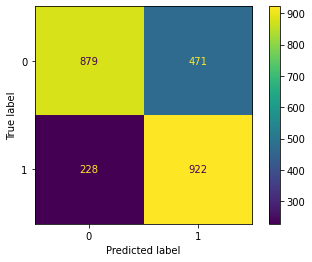

In [ ]:
cm_display_svm.plot()
plt.show()

In [ ]:
confusion_matrix_rnd = confusion_matrix(y_test, y_pred_rnd)

In [ ]:
cm_display_rnd = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rnd, display_labels = [0,1])

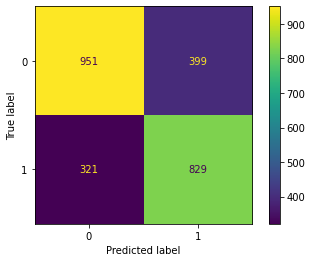

In [ ]:
cm_display_rnd.plot()
plt.show()